In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
file_dict = os.path.dirname(os.getcwd())
print(file_dict)

d:\Nirmal\2022 FALL MIT\RA Documents\GenX\GenX_CO2\GenX\fusion_paper\paper_runs


In [7]:
## Dictionaries to rename resources and give colors

res_name = {
    'solar_pv_2': 'Solar',
    'onshore_wind_2': 'Onshore_Wind',
    'fixed_offshore_wind_2': 'Offshore_Fixed',
    'floating_offshore_wind_2': 'Offshore_Floating',
    'natural_gas_2': 'NGCC',
    'natural_gas_ccs_2': 'NGCCS',
    'battery_2': '4hr_Battery',
    'nuclear_2': 'Nuclear',
    'fusion_2': 'Fusion',
    'ror_hydro_2': 'ROR',
    'res_hydro_1': 'QC_Hydro',
    'pumped_hydro_2': 'PHS'
}

res_color = {
    'Solar': '#fdae61',
    'Onshore_Wind': '#abd9e9',
    'Offshore_Fixed': '#2c7bb6',
    'Offshore_Floating': '#2c7bb6',
    'NGCC': '#d7191c',
    'NGCCS': '#d7191c',
    '4hr_Battery': '#ffffbf',
    'Nuclear': '#fdae61',
    'Fusion': '#fdae61',
    'ROR': '#abd9e9',
    'QC_Hydro': '#2c7bb6',
    'PHS': '#2c7bb6'
}

## 20 year capacity visualization

In [11]:
## Read capacity files for both 20 year fusion and no_fusion cases

fus_20 = pd.read_csv(f'{file_dict}/fus_20_results/capacity.csv')
nofus_20 = pd.read_csv(f'{file_dict}/nofus_20_results/capacity.csv')

## Make a dataframe for power capacity
cap_df = pd.DataFrame({'Resource' : fus_20['Resource'], 'Capacity(MW)_Fusion' : fus_20['EndCap'], 'Capacity(MW)_NoFusion' : nofus_20['EndCap']})
cap_df['Resource'] = cap_df['Resource'].replace(res_name)


## Make a dataframe for energy capacity
energy_df = pd.DataFrame({'Resource' : fus_20['Resource'], 'EnergyCapacity(MWh)_Fusion' : fus_20['EndEnergyCap'], 'EnergyCapacity(MWh)_NoFusion' : nofus_20['EndEnergyCap']})
energy_df['Resource'] = energy_df['Resource'].replace(res_name)

ValueError: The number of FixedLocator locations (22), usually from a call to set_ticks, does not match the number of labels (2).

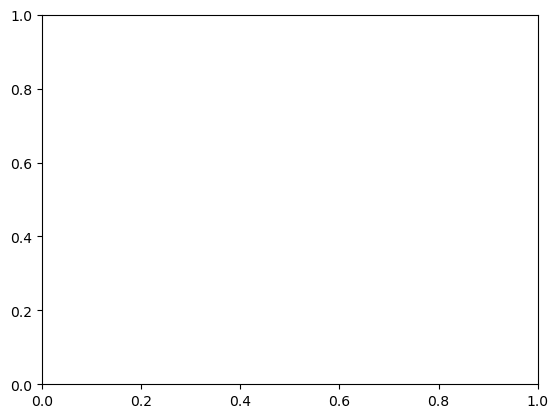

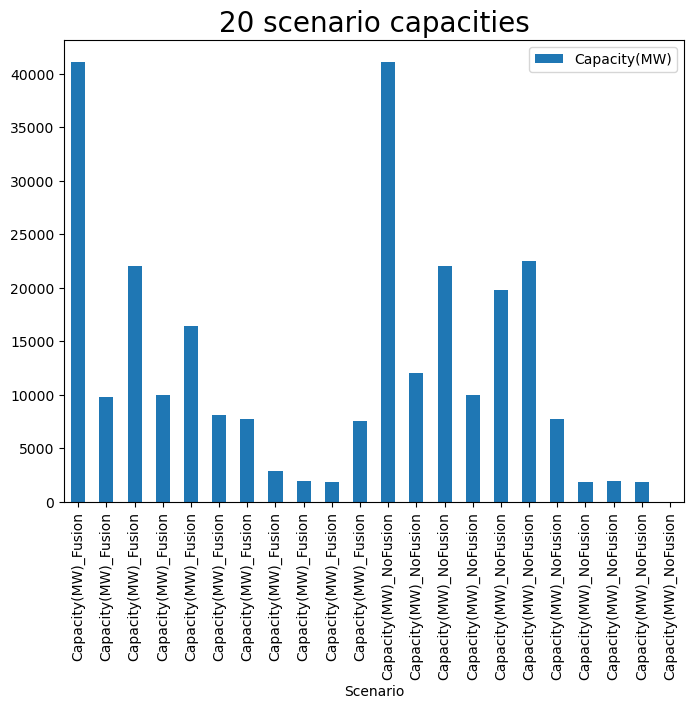

In [19]:
## 20 year capacity comparison ##

# Comparison with QC Hydro
cap_df = cap_df[~cap_df['Resource'].isin(['Nuclear', 'Total'])]

# Change to long form data
cap_transposed = cap_df.melt(id_vars=['Resource'], var_name='Scenario', value_name='Capacity(MW)')


# Create the side-by-side stacked bar chart
width = 0.5
fig, ax = plt.subplots()


ax = cap_transposed.plot.bar(x='Scenario', stacked=True, figsize=(8,6))
ax.set_title('20 scenario capacities', fontsize=20)
# ax.set_ylim(0,500)
ax.set_xticklabels(['Fusion','No_Fusion'], rotation=0)



# for idx, row in cap_df.iterrows():
#     resource = row['Resource']
#     plt.bar(x, row['Capacity(MW)_Fusion'], width, color=res_color.get(resource, 'gray'), label='Capacity(MW)_Fusion')
#     plt.bar(x, row['Capacity(MW)_NoFusion'], width, bottom=row['Capacity(MW)_Fusion'], color=res_color.get(resource, 'gray'), label='Capacity(MW)_NoFusion')

# Set labels and legend
# plt.xlabel('Resource')
# plt.ylabel('Capacity (MW)')
# plt.title('Capacity of Resources')
# plt.legend()

# # Set x-axis ticks and labels
# plt.xticks(x, cap_df['Resource'], rotation=45, ha='right')

# # Show the plot
# plt.tight_layout()
# plt.show()


